In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:
# stanza pipeline for constituency and dependency parsing
import stanza
nlp = stanza.Pipeline('zh')

In [4]:
 # functions and data structures for feature extraction
from collections import defaultdict
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import json
import random
#构造嵌套字典
def tree():
    return defaultdict(tree)
#去掉空格
def split_string(text):
    result = []
    tmp = ""
    flag = 0
    for char in text:
        if char == ' ':
            flag = 0
            if tmp != "":
                result.append(tmp)
                tmp = ""
            continue
        elif char == '(':
            flag = 1
            result.append(char)
            continue
        elif char == ')':
            result.append(char)
            continue
        elif flag == 1:
            tmp += char
            continue
    return result, ''.join(result)

class Stack:
    def __init__(self):
        self.items = []

    def is_empty(self):
        return self.items == []

    def push(self, item):
        self.items.append(item)

    def pop(self):
        if not self.is_empty():
            return self.items.pop()
        else:
            print("Stack is empty")

    def top(self):
        if not self.is_empty():
            return self.items[-1]
        else:
            print("Stack is empty")

    def size(self):
        return len(self.items)

#将递归的 defaultdict 转换为普通的嵌套字典。
def dicts(t): return {k: dicts(t[k]) for k in t}

def build_constituency_feature_tree(text, MAXLAYER=3):
    treeStrList, tmp = split_string(text)
    featureTree = tree()
    stack = Stack()
    i = 0
    layer = -1
    while i < len(treeStrList):
        if treeStrList[i] == '(':
            i+=1
            layer+=1
            if layer <= MAXLAYER:
                if(stack.is_empty()):
                    featureTree[treeStrList[i]]
                    stack.push(featureTree[treeStrList[i]])
                else:
                    if(treeStrList[i] in stack.top()):
                        keytmp = treeStrList[i] + str(random.randint(1, 100000)) #发现重复键，则附加随机数
                    else:
                        keytmp = treeStrList[i]
                    stack.top()[keytmp]
                    stack.push(stack.top()[keytmp])
            i+=1
            continue
        if treeStrList[i] == ')':
            if layer > 0 and layer <= MAXLAYER:
                stack.pop()
            layer-=1
            i+=1
            continue
    return dicts(featureTree)['ROOT']

def extract_constituency_feature_from_tree(feature_tree):
    queue = []
    result = []
    queue.append(feature_tree)
    while len(queue) > 0:
        tmp = queue.pop()
        for key in tmp.keys():
            if isinstance(tmp[key], dict) and len(tmp[key]) > 0:
                queue.append(tmp[key])
                # 去除数字
                result.append(''.join(char for char in str({key: tmp[key]}) if not char.isdigit()))
    return result

# zcy fix return type, Time: 2025.01.16
def extract_dependency_feature_from_list(words):
    sent_list = []
    for word in words:
        head_id = word.head
        head_upos = "ROOT" if head_id == 0 else words[head_id - 1].upos  # 获取 head 的 UPOS
        pos_list = [word.upos, head_upos, word.deprel]
        head_lemma = "NONE" if head_id == 0 else words[head_id - 1].lemma
        lex_list = [word.lemma, head_lemma, word.deprel]
        sent_list.append([f'{pos_list}', f'{lex_list}'])
    return sent_list

def parse_tmx(file):
    # 解析 XML 文件
    tree = ET.parse(file)
    root = tree.getroot()

    # 找到 TMX 文件中的 body 部分
    body = root.find("body")
    if body is None:
        raise ValueError("Invalid TMX file: missing <body> section.")

    # 遍历所有 <tu> 元素
    for tu in body.findall("tu"):
        translations = {}
        # 提取每个 <tu> 中的 <tuv> 元素
        for tuv in tu.findall("tuv"):
            lang = tuv.attrib.get("{http://www.w3.org/XML/1998/namespace}lang")  # 获取语言属性
            seg = tuv.find("seg")
            if lang and seg is not None:
                translations[lang] = seg.text.strip()

        # 如果有源语言和目标语言，返回一对
        if "en-US" in translations and "zh-CN" in translations:
            yield translations["en-US"], translations["zh-CN"]

def list_txt_files(folder_path):
    result = []
    # 遍历文件夹及其子文件夹中的所有文件
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.txt'):  # 只处理以 .txt 结尾的文件
                file_path = os.path.join(root, file)
                result.append(file_path)  # 返回文件的完整路径
    return result

In [ ]:
#orig calculate dep and const feature
#sy
Constituency_feature_count_map = defaultdict(int)
Dependency_feature_count_map = defaultdict(int)
for file in tqdm(list_txt_files("./LCMC_txt"), total=88, desc="Processing", unit="file"):
    with open(file, "r", encoding="utf-8") as file:
        for line in file:
            if line == '\n':
                continue
            doc = nlp(line)
            # Constituency
            m = str(doc.sentences[0].constituency)
            layer_2_feature_tree = build_constituency_feature_tree(m, 2)
            sec_feature_list = extract_constituency_feature_from_tree(layer_2_feature_tree)
            for i in sec_feature_list:
                Constituency_feature_count_map[i] += 1
            
            layer_3_feature_tree = build_constituency_feature_tree(m, 3)
            sec_feature_list = extract_constituency_feature_from_tree(layer_3_feature_tree)
            for i in sec_feature_list:
                Constituency_feature_count_map[i] += 1
           
            # Dependency
            words = doc.sentences[0].words
            dependency_list = extract_dependency_feature_from_list(words)
            for dep in dependency_list:
                Dependency_feature_count_map[dep[0]] += 1
sorted_const_data = dict(sorted(Constituency_feature_count_map.items(), key=lambda item: item[1], reverse=True))

sorted_dep_data = dict(sorted(Dependency_feature_count_map.items(), key=lambda item: item[1], reverse=True))

with open(f'./orig_constituency_feature_count.json', 'w', encoding='utf-8') as f:
    json.dump(sorted_const_data, f, ensure_ascii=False, indent=4)
with open(f'./orig_dependency_feature_count.json', 'w', encoding='utf-8') as f:
    json.dump(sorted_dep_data, f, ensure_ascii=False, indent=4)

Processing:   1%|          | 1/88 [35:47<51:54:25, 2147.89s/file]


KeyboardInterrupt: 

In [ ]:
#上一步手动将orig的const和dep feature中出现次数大于5的复制到json中，修改json文件名为orig_all_feature.json
#sy


In [ ]:
#combined_all_feature.json
#orig和ins去重+放到同一个字典里，key是feature，value是index
all_feature = {}
with open('./orig_all_feature.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    all_feature.update(data)
with open('./ins_all_feature.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    all_feature.update(data)

for index,key in enumerate(all_feature.keys()):
    all_feature[key] = index

with open('./combined_all_feature.json', 'w', encoding='utf-8') as f:
    json.dump(all_feature, f, ensure_ascii=False, indent=4)
    

In [ ]:
#vector
build_feature_vec = {}
with open('./combined_all_feature.json', 'r', encoding='utf-8') as f:
    combined_all_feature = json.load(f)

x = []
y = []
#go through sentences in LCMC, build feature vector
for file in tqdm(list_txt_files("./LCMC_txt"), total=3, desc="Processing", unit="file"):
    with open(file, "r", encoding="utf-8") as file:
        for line in file:
            if line == "":
                continue
            doc = nlp(line)
            sent_vec = [0] * len(combined_all_feature)
            #constituency
            m = str(doc.sentences[0].constituency)
            result = build_constituency_feature_tree(m, 2)
            ff = extract_constituency_feature_from_tree(result)
            for item in ff:
                if item in combined_all_feature.keys():
                    sent_vec[combined_all_feature[item]] += 1
            result = build_constituency_feature_tree(m, 3)
            ff = extract_constituency_feature_from_tree(result)
            for item in ff:
                if item in combined_all_feature.keys():
                    sent_vec[combined_all_feature[item]] += 1
            #dependency
            m = doc.sentences[0].words
            result = extract_dependency_feature_from_list(m)
            for item in result:
                if item[0] in combined_all_feature.keys():
                    sent_vec[combined_all_feature[item[0]]] += 1
            x.append(sent_vec)
            y.append(0)

#go through sentences in insructed txt, build feature vector
for file in tqdm(list_txt_files("./ins_txt"), total=3, desc="Processing", unit="file"):
    with open(file, "r", encoding="utf-8") as file:
        for line in file:
            if line == "":
                continue
            doc = nlp(line)
            sent_vec = [0] * len(combined_all_feature)
            #constituency
            m = str(doc.sentences[0].constituency)
            result = build_constituency_feature_tree(m, 2)
            ff = extract_constituency_feature_from_tree(result)
            for item in ff:
                if item in combined_all_feature.keys():
                    sent_vec[combined_all_feature[item]] += 1
            result = build_constituency_feature_tree(m, 3)
            ff = extract_constituency_feature_from_tree(result)
            for item in ff:
                if item in combined_all_feature.keys():
                    sent_vec[combined_all_feature[item]] += 1
            #dependency
            m = doc.sentences[0].words
            result = extract_dependency_feature_from_list(m)
            for item in result:
                if item[0] in combined_all_feature.keys():
                    sent_vec[combined_all_feature[item[0]]] += 1
            x.append(sent_vec)
            y.append(1)

with open('./x.txt', 'w', encoding='utf-8') as f:
    for item in x:
        f.write(f"{item}\n")
with open('./y.txt', 'w', encoding='utf-8') as f:
    for item in y:
        f.write(f"{item}\n")
        

In [8]:
# 读取文件内容
with open("x.txt", "r") as file:
    content = file.read()

# 去掉多余字符（如方括号和换行符），将字符串转换为二维列表
content = content.replace('[', '').replace(']', '').strip()
data = [list(map(int, row.split(','))) for row in content.split('\n')]
# 转换为 NumPy 数组
x = np.array(data)
# 读取文件内容
with open("y.txt", "r") as file:
    content = file.readlines()

# 去掉换行符并转换为整数
y = np.array([int(line.strip()) for line in content])

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# 创建模型
clf = RandomForestClassifier(n_estimators=100, random_state=42)
for fold, (train_index, test_index) in enumerate(kf.split(x)):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"第 {fold+1} 折准确率: {score:.4f}")

第 1 折准确率: 0.7698
第 2 折准确率: 0.7901
第 3 折准确率: 0.7860
第 4 折准确率: 0.7801
第 5 折准确率: 0.7724


In [15]:
# 读取字典
with open('./combined_all_feature.json', 'r', encoding='utf-8') as f:
    feature_names = json.load(f)
# 反转字典：交换 key 和 value
reversed_dict = {v: k for k, v in feature_names.items()}

特征重要性排名：
['VERB', 'VERB', 'advcl']: 0.0217
['NOUN', 'NOUN', 'nmod']: 0.0200
['PRON', 'VERB', 'nsubj']: 0.0199
['NOUN', 'VERB', 'obj']: 0.0174
['PUNCT', 'VERB', 'punct']: 0.0172
['NUM', 'NOUN', 'nummod']: 0.0168
['X', 'X', 'flat:foreign']: 0.0168
['ADV', 'VERB', 'advmod']: 0.0137
['ADP', 'NOUN', 'case']: 0.0135
['NOUN', 'VERB', 'nsubj']: 0.0134
['DET', 'NOUN', 'det']: 0.0132
['AUX', 'VERB', 'aux']: 0.0131
['PUNCT', 'NOUN', 'punct']: 0.0124
['ADV', 'VERB', 'mark']: 0.0116
['NOUN', 'NOUN', 'clf']: 0.0108
['ADJ', 'NOUN', 'amod']: 0.0108
['VERB', 'VERB', 'ccomp']: 0.0106
['VERB', 'VERB', 'xcomp']: 0.0102
['PROPN', 'NOUN', 'nmod']: 0.0102
['PART', 'VERB', 'mark:rel']: 0.0100
['X', 'NOUN', 'nmod']: 0.0099
['X', 'VERB', 'nsubj']: 0.0098
['PART', 'ADJ', 'mark:rel']: 0.0096
['PART', 'NOUN', 'case']: 0.0096
['PUNCT', 'PROPN', 'punct']: 0.0093
{'IP': {'NP': {}, 'VP': {}, '.': {}, "''": {}}}: 0.0092
['NOUN', 'VERB', 'obl']: 0.0087
['VERB', 'NOUN', 'acl:relcl']: 0.0085
['PART', 'PRON', 'case']: 0.00

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20160\778867085.py:17: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20160\778867085.py:17: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20160\778867085.py:17: UserWarning: Glyph 21517 (\N{CJK UNIFIED IDEOGRAPH-540D}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20160\778867085.py:17: UserWarning: Glyph 31216 (\N{CJK UNIFIED IDEOGRAPH-79F0}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20160\778867085.py:17: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_20160\778867085.py:17: UserWarning: Glyph 3

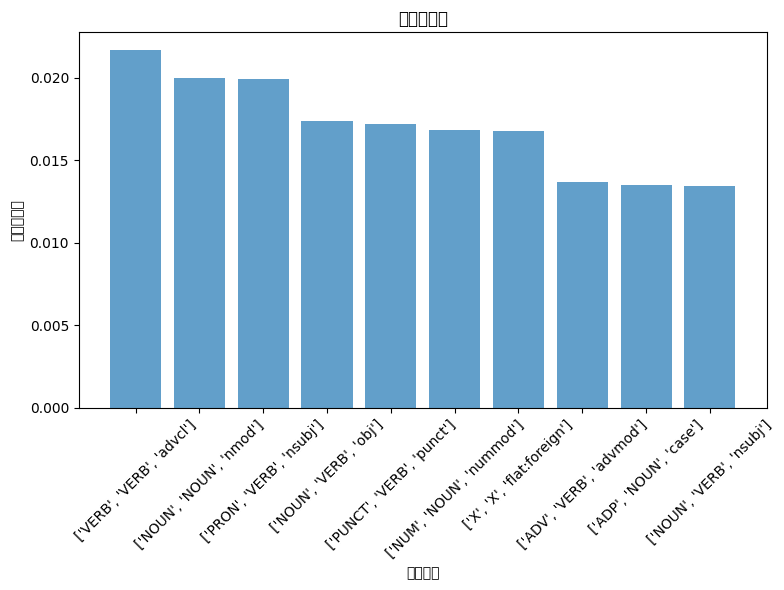

In [19]:
# 提取特征重要性
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# 打印特征重要性
print("特征重要性排名：")
for i in indices:
    print(f"{reversed_dict[i]}: {importances[i]:.4f}")

# 可视化
plt.figure(figsize=(8, 6))
plt.bar(range(10), importances[indices][:10], align='center', alpha=0.7)
plt.xticks(range(10), [reversed_dict[i] for i in indices[:10]], rotation=45)
plt.xlabel('特征名称')
plt.ylabel('重要性得分')
plt.title('特征重要性')
plt.tight_layout()
plt.show()

In [ ]:
# orig build vec
# ed
with open('./all_feature_index.json', 'r', encoding='utf-8') as f:
    updated_data = json.load(f)
result_vec = []
dic_re = []
for file in tqdm(list_txt_files("./LCMC_txt"), total=3, desc="Processing", unit="file"):
    with open(file, "r", encoding="utf-8") as file:
        for line in file:
            if line == "":
                doc = nlp(line)
                l1 = [0] * 629
                dict_ft_txt = {}
                # Constituency
                m = str(doc.sentences[0].constituency)
                result = build_constituency_feature_tree(m, 2)
                ff = extract_constituency_feature_from_tree(result)
                for item in ff:
                    if item in updated_data:
                        l1[updated_data[item]] += 1
                        dict_ft_txt[updated_data[item]] = item
                result = build_constituency_feature_tree(m, 3)
                ff = extract_constituency_feature_from_tree(result)
                for item in ff:
                    if item in updated_data:
                        l1[updated_data[item]] += 1
                        dict_ft_txt[updated_data[item]] = item
            
                # Dependency
                words = doc.sentences[0].words
                dependency_list = extract_dependency_feature_from_list(words)
                for dep in dependency_list:
                    if dep[0] in updated_data:
                        l1[updated_data[dep[0]]] += 1
                        dict_ft_txt[updated_data[dep[0]]] = dep[1]
                dic_re.append(dict_ft_txt)
                result_vec.append(l1)


In [17]:
#index orig feature 
#sy
# ed
with open('./all_feature.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

#TODO: 检查data是否是字典

# 遍历字典，将值改为递增的索引
updated_data = {}
for index, key in enumerate(data.keys()):
    updated_data[key] = index

# 写入新的 JSON 文件
with open('./all_feature_index.json', 'w', encoding='utf-8') as f:
    json.dump(updated_data, f, ensure_ascii=False, indent=4)

FileNotFoundError: [Errno 2] No such file or directory: './all_feature.json'

In [4]:
feature_count_map = defaultdict(int)


In [ ]:
#instruct提取成分句法
# ed
i = 0
for file in tqdm(list_txt_files("./instruct_txt"), total=88, desc="Processing", unit="file"):
    ll = []
    with open(file, "r", encoding="utf-8") as file:
        for line in file:
            ll.append(line)
            doc = nlp(line)
        
            # Constituency
            m = str(doc.sentences[0].constituency)
            ll.append(m)
            result = build_constituency_feature_tree(m, 2)
            ll.append("layer 2:")
            ff = extract_constituency_feature_from_tree(result)
            for item in ff:
                ll.append(item)
                feature_sentences_map[item].append(line)
            result = build_constituency_feature_tree(m, 3)
            ll.append("layer 3:")
            ff = extract_constituency_feature_from_tree(result)
            for item in ff:
                ll.append(item)
                feature_sentences_map[item].append(line)
        
            # Dependency
            words = doc.sentences[0].words
            dependency_list = extract_dependency_feature_from_list(words)
            ll.append("Dependency Features:")
            for dep in dependency_list:
                ll.append(dep)  # 用制表符拼接特征
        
            ll.append("----------------------------------------------------------------------")
    
            with open(f'./tmp/feature{i}.txt', 'w', encoding='utf-8') as f:
                f.write('\n'.join(ll))
        i+=1

In [5]:
feature_sentences_map = defaultdict(list)

In [7]:
#orig building tmp
i = 0
for file in tqdm(list_txt_files("./LCMC_txt"), total=3, desc="Processing", unit="file"):
    ll = []
    with open(file, "r", encoding="utf-8") as file:
        for line in file:
            if line != '\n':
                ll.append(line)
                doc = nlp(line)
        
                # Constituency
                m = str(doc.sentences[0].constituency)
                ll.append(m)
                result = build_constituency_feature_tree(m, 2)
                ll.append("layer 2:")
                ff = extract_constituency_feature_from_tree(result)
                for item in ff:
                    ll.append(item)
                    # feature_sentences_map[item].append(line)
                result = build_constituency_feature_tree(m, 3)
                ll.append("layer 3:")
                ff = extract_constituency_feature_from_tree(result)
                for item in ff:
                    ll.append(item)
                    # feature_sentences_map[item].append(line)
            
                # Dependency
                words = doc.sentences[0].words
                dependency_list = extract_dependency_feature_from_list(words)
                ll.append("Dependency Features:")
                for dep in dependency_list:
                    ll.append(str(dep))  # 用制表符拼接特征
            
                ll.append("----------------------------------------------------------------------")
        
    with open(f'./orig_tmp/feature{i}.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(ll))
    i+=1

Processing: 100%|██████████| 3/3 [21:46<00:00, 435.34s/file]


In [3]:
#提取成分句法
# zcy add Time: 2025.01.16

Dependency_feature_count_map = defaultdict(int)
for file in tqdm(list_txt_files("./instruct_txt"), total=88, desc="Processing", unit="file"):
    with open(file, "r", encoding="utf-8") as file:
        for line in file:
            doc = nlp(line)
        
            # Dependency
            words = doc.sentences[0].words
            dependency_list = extract_dependency_feature_from_list(words)
            for dep in dependency_list:
                Dependency_feature_count_map[dep[0]] += 1
sorted_data = dict(sorted(Dependency_feature_count_map.items(), key=lambda item: item[1], reverse=True))

with open(f'./dependency_feature_count.json', 'w', encoding='utf-8') as f:
    json.dump(sorted_data, f, ensure_ascii=False, indent=4)

Processing: 100%|██████████| 88/88 [10:40<00:00,  7.28s/file]


In [ ]:
# zcy add Time: 2025.01.16
# 读取 JSON 文件
with open('./all_feature.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

#TODO: 检查data是否是字典

# 遍历字典，将值改为递增的索引
updated_data = {}
for index, key in enumerate(data.keys()):
    updated_data[key] = index

# 写入新的 JSON 文件
with open('./all_feature_index.json', 'w', encoding='utf-8') as f:
    json.dump(updated_data, f, ensure_ascii=False, indent=4)

In [4]:
# zcy add Time: 2025.01.16

with open('./all_feature_index.json', 'r', encoding='utf-8') as f:
    updated_data = json.load(f)
result_vec = []
dic_re = []
for file in tqdm(list_txt_files("./instruct_txt"), total=88, desc="Processing", unit="file"):
    with open(file, "r", encoding="utf-8") as file:
        for line in file:
            doc = nlp(line)
            l1 = [0] * 629
            dict_ft_txt = {}
            # Constituency
            m = str(doc.sentences[0].constituency)
            result = build_constituency_feature_tree(m, 2)
            ff = extract_constituency_feature_from_tree(result)
            for item in ff:
                if item in updated_data:
                    l1[updated_data[item]] += 1
                    dict_ft_txt[updated_data[item]] = item
            result = build_constituency_feature_tree(m, 3)
            ff = extract_constituency_feature_from_tree(result)
            for item in ff:
                if item in updated_data:
                    l1[updated_data[item]] += 1
                    dict_ft_txt[updated_data[item]] = item
        
            # Dependency
            words = doc.sentences[0].words
            dependency_list = extract_dependency_feature_from_list(words)
            for dep in dependency_list:
                if dep[0] in updated_data:
                    l1[updated_data[dep[0]]] += 1
                    dict_ft_txt[updated_data[dep[0]]] = dep[1]
            dic_re.append(dict_ft_txt)
            result_vec.append(l1)


Processing: 100%|██████████| 88/88 [11:11<00:00,  7.63s/file]


In [11]:
# zcy add Time: 2025.01.17
with open('all_line_feature.json', 'w', encoding='utf-8') as f:
    json.dump(dic_re, f, ensure_ascii=False, indent=4)



In [15]:
# zcy add Time: 2025.01.17
with open("./all_line_vec.txt", "w", encoding="utf-8") as file:
    for row in result_vec:
        file.write(str(row) + "\n")  # 将每行写入，并添加换行符

In [40]:
#lemma是当前token
sent = '这并不一定是坏事，尤其是它向日本和韩国这两个盟友发出了几个至关重要的信息。'
doc = nlp(sent)
# print(doc.sentences[0])
for i in doc.sentences[0].words:
    head_id = i.head
    print(i.lemma, doc.sentences[0].words[head_id-1].lemma, i.deprel)

这 是 nsubj
并 坏事 mark
不 坏事 advmod
一定 坏事 advmod
是 坏事 cop
坏事 是 advcl
， 坏事 punct
尤其 是 advmod
是 。 root
它 发出 nsubj
向 日本 case
日本 发出 obl
和 韩国 cc
韩国 日本 conj
这 个 det
两 个 nummod
个 盟友 nmod
盟友 发出 obl
发出 是 ccomp
了 发出 aux
几 个 nummod
个 信息 clf
至关重要 信息 amod
的 至关重要 mark:rel
信息 发出 obj
。 是 punct


In [ ]:
# test提取依存树 暂时不用，好像错删了什么
def extract_dependency_feature_from_list(dependency_list):
    #lemma是当前token
    sent = '这并不一定是坏事，尤其是它向日本和韩国这两个盟友发出了几个至关重要的信息。'
    doc = nlp(sent)
# print(doc.sentences[0])
    for i in doc.sentences[0].words:
        head_id = i.head
        print(i.lemma, doc.sentences[0].words[head_id-1].lemma, i.deprel)
    
    # result = []
    # for dep in dependency_list:
    #     word = dep[0]
    #     head_word = dep[1]
    #     relation = dep[2]
    #     head_upos = head_word.upos
    #     result.append(f"{word.upos}/{head_upos}/{relation} {word.text}/{head_word.text if head_word else 'ROOT'}/{relation}")
    # return result

# 测试构造 tmp/test_feature.txt
ll = []
feature_sentences_map = defaultdict(list)
with open('./instruct_txt/A01A_en_zh.txt', "r", encoding="utf-8") as file:
    for line in file:
        ll.append(line.strip())
        doc = nlp(line)
        
        # Constituency tree
        if hasattr(doc.sentences[0], 'constituency'):
            m = str(doc.sentences[0].constituency)
            ll.append(m)
        else:
            ll.append("No constituency analysis available.")
            continue


        
        # Dependency tree
        # for sentence in doc.sentences:
        #     dependency_list = []
        #     for word in sentence.words:
        #         head_word = sentence.words[word.head - 1] if word.head > 0 else None
        #         dependency_list.append((word, head_word, word.deprel))
        #     ll.append("\n".join(extract_dependency_feature_from_list(dependency_list)))

        ll.append("----------------------------------------------------------------------")

# 输出到文件
with open('tmp/test_feature.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(ll))

AttributeError: 'NoneType' object has no attribute 'upos'

In [8]:
sorted_data = dict(sorted(feature_count_map.items(), key=lambda item: item[1], reverse=True))
with open('feature_count.json', 'w', encoding='utf-8') as f:
    json.dump(sorted_data, f, ensure_ascii=False, indent=4)

In [9]:
sorted_sentences_data = dict(sorted(feature_sentences_map.items(), key=lambda item: len(item[1]), reverse=True))
with open('feature_sentences.json', 'w', encoding='utf-8') as f:
    json.dump(sorted_sentences_data, f, ensure_ascii=False, indent=4)

In [ ]:
text_book = ['(ROOT (IP (IP (NP (NNP 平壤)) (VP (MD 可能) (VP (ADVP (RB 也)) (ADVP (RB 在)) (VP (VV 准备) (IP (VP (VV 试射) (NP (QP (CD 一) (CLP (NNB 枚))) (NP (NP (FW Taepo)) (FW Dong-2)) (NP (NN 导弹))))))))) (, ，) (IP (LCP (NP (NN 理论)) (IN 上)) (, ，) (NP (DP (DT 这) (CLP (NNB 种))) (NP (NN 导弹))) (VP (MD 可以) (VP (VP (VV 携带) (NP (NN 核弹) (SFN 头))) (, ，) (VP (VV 覆盖) (NP (DP (DT 整个)) (NP (NNP 美国)) (NP (NN 大陆))))))) (. 。)))']

result = build_constituency_feature_tree(text_book[0], 3)
print(result)

ff = extract_constituency_feature_from_tree(result)
for item in ff:
    print(item)



{'IP': {'IP': {'NP': {}, 'VP': {}}, ',': {}, 'IP83738': {'LCP': {}, ',': {}, 'NP': {}, 'VP': {}}, '.': {}}}
{'IP': {'IP': {'NP': {}, 'VP': {}}, ',': {}, 'IP': {'LCP': {}, ',': {}, 'NP': {}, 'VP': {}}, '.': {}}}
{'IP': {'NP': {}, 'VP': {}}}
{'IP': {'LCP': {}, ',': {}, 'NP': {}, 'VP': {}}}


In [51]:
print(extract_dependency_feature_from_list(m))

['NOUN/NUM/nummod', 'VERB/NOUN/nsubj', 'VERB/ADV/mark', 'VERB/ADV/advmod', 'VERB/VERB/advcl', 'VERB/ADV/mark', 'None/VERB/root', 'VERB/AUX/aux', 'VERB/NOUN/nmod:tmod', 'VERB/VERB/xcomp', 'NOUN/NUM/nummod', 'VERB/NOUN/obj', 'VERB/PUNCT/punct']
